In [5]:
"""
CEOAE cepstral analysis algorithm

Author: havlajos
Created: 15/05/2023
Last Update: 11/07/2023

Description: Analysis of the phase-gradient delay of CEOAE data using the cepstral analysis algorithm.
"""

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from peak_picking import *

# CEOAE data loading
FILENAME = "data/ceoae2/ceoae50g130R29rs20.mat"
mat_CEOAE = scipy.io.loadmat(FILENAME)

fs = mat_CEOAE['fs'].flatten()  # sample rate
CEOAE = mat_CEOAE['click50'].flatten()  # CEOAE wave
time_axis = np.arange(0, np.size(CEOAE)/fs, 1/fs)

# we cut off spectrum because our reference is only at isolated frequencies
spectrum = np.fft.fft(CEOAE)
fx = np.arange(len(spectrum))*fs/len(spectrum)
spectrum = spectrum[(fx >= 0) & (fx <= 6000)]
fx = fx[(fx >= 0) & (fx <= 6000)]

# unwrapped phase of the SFOAE wave
phase_unwrap_CEOAE = np.unwrap(np.angle(spectrum))

freq_range_CEOAE = np.size(fx)  # maximum index on the frequency axis

# peak picking
maximas_CEOAE = findLocalMaxima(np.real(20*np.log10(spectrum)))
shift = 1  # 3 points around all peaks (the peak is included)
ext_maximas_CEOAE = peakNeighbours(maximas_CEOAE, shift, np.size(fx))


In [6]:
from cutoff_window import *
from scipy.interpolate import CubicSpline
from cepstrum_smoothing import *
from peak_picking import *
from gradient_delay import *

# an estimate of the secular variation of the unwrapped phase from which much of the phase rippling pattern has been ironed out
phi = smoothedPhi(phase_unwrap_CEOAE)
# cutoff to have only an increasing tendency
phi_first_loc_max = findLocalMaxima(phi)[0] + 1

# ----------------------------------------------------
# plotting the smoothed phi
'''
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(freq_SFOAE, phi, "b--", label="Smoothed phi")
ax.plot(freq_SFOAE[phi_first_loc_max], phi[phi_first_loc_max], "rx")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Unwrapped phase (rad)")
plt.title("Smoothed phi variable with local maxima")
plt.legend()
plt.show()
'''

frequency_interest = 3000  # until which frequency (Hz) are we interested
while (fx[phi_first_loc_max] <= frequency_interest):
    # erasing the local maxima to have an increasing tendency
    phi = np.delete(phi, phi_first_loc_max)
    phi_first_loc_max = findLocalMaxima(phi)[0]

phi_first_loc_max += 1
# ----------------------------------------------------

# resampling phi
phi_N_samples = 1000
phi_resample = np.linspace(0, np.floor(
    phi[phi_first_loc_max-1]), phi_N_samples)

# calculation of the number of cycles travelled by phi
# phi is already in cycles (no need to divide by 2pi)
N_cycles = np.round(np.max(phi) - np.min(phi))
# N_cycles = 16

# calculate logarithm of SFOAE
log_SFOAE = np.log(spectrum)  # = np.log(np.abs(SFOAE)) + 1j*phase_unwrap_SFOAE

# cubic spline interpolation SEPARATELY for the real and imaginary part (resample w.r.t. to phi)
real_log_SFOAE_interp = CubicSpline(
    phi[:phi_first_loc_max], np.real(log_SFOAE[:phi_first_loc_max]))
# unwrapping to avoid phase jumps
imag_log_SFOAE_interp = CubicSpline(
    phi[:phi_first_loc_max], np.unwrap(np.imag(log_SFOAE[:phi_first_loc_max])))

'''
# linear interpolation
real_log_SFOAE_interp = np.interp(phi_resample,phi[:phi_end], np.real(log_SFOAE[:phi_end]))
imag_log_SFOAE_interp = np.interp(phi_resample,phi[:phi_end], np.unwrap(np.imag(log_SFOAE[:phi_end])))
'''

# evaluating the interpolated data on the resampled phi
real_log_SFOAE_values = real_log_SFOAE_interp(phi_resample)
imag_log_SFOAE_values = imag_log_SFOAE_interp(
    phi_resample)  # + 2*np.pi*phi_resample

# plotting the real and imaginary values
'''
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(real_log_SFOAE_values, label="Real part")
ax.plot(imag_log_SFOAE_values, label="Imaginary part")
plt.legend()
plt.show()
'''

# wrapping up back the phi into <-pi; +pi>
# 2*np.pi*phi_resample  ~ full phase cycle is 2*pi radians
# + np.pi               ~ shifting the range to be centered at zero for <-pi; +pi>
# % (2 * np.pi)         ~ to obtain a resulte between <0; +2*pi>
# - np.pi               ~ to shift into <-pi; +pi> interval
wrapped_phi = (2*np.pi*phi_resample + np.pi) % (2 * np.pi) - np.pi

# Eq. 18, calculation of F(X(phi) + j*2*pi*phi) -> perform FFT with respect to phi
# "Computing the transforms of its real and imaginary parts separately often proves convenient"
fft_log_SFOAE_phi = np.fft.fft(
    real_log_SFOAE_values) + 1j*np.fft.fft(imag_log_SFOAE_values + 2*np.pi*phi_resample)
# fft_log_SFOAE_phi = np.fft.fft(real_log_SFOAE_values*np.exp(1j*imag_log_SFOAE)) + 1j*np.fft.fft(imag_log_SFOAE_values)

fft_log_SFOAE_only_real = np.fft.fft(real_log_SFOAE_values)

# obtain the quefrency axis
sample_rate = 1/(phi_resample[1]-phi_resample[0])
quefrency = np.arange(len(phi_resample))*sample_rate/(len(phi_resample))

# cutoff window
cutoff_coeff = 0.5
eta_c = cutoff_coeff*N_cycles  # quefrency cutoff

smooth_order = 10  # order of the smoothing function
window = getWindow(quefrency, eta_c, smooth_order)  # cutoff window

# plotting the comparison of cuttoff window and F{log(X)}
'''
fig, ax = plt.subplots(figsize=(9,4))
ax.semilogx(quefrency/eta_c, np.abs(fft_log_SFOAE_only_real)/100, label="abs(F{real_log(X)})")
ax.semilogx(quefrency/eta_c, np.abs(fft_log_SFOAE_phi)/100, label="abs(F{log(X)})")
ax.semilogx(quefrency/eta_c, window, label="Cutoff window")
ax.set_xlim((0.1, 3))
ax.set_ylim((0, 1.1))
plt.xlabel("Quefrency/cutoff")
plt.title("Cutoff window detail")
plt.legend()
plt.show()
'''

# obtaining the smoothed signal -> apply the window function to the FFT output in order to cutoff at eta_c quefrency
log_0_SFOAE = np.fft.ifft(window*fft_log_SFOAE_phi) - 1j*wrapped_phi
# log_0_SFOAE = np.fft.ifft(window*fft_log_SFOAE_phi) - 2*np.pi*1j*phi_resample

# from LOG(SFOAE) to SFOAE
smooth_SFOAE = np.exp(np.real(log_0_SFOAE)) * \
    np.exp(1j*np.unwrap(np.imag(log_0_SFOAE)))
smooth_phase = np.unwrap(np.angle(smooth_SFOAE))

# cubic spline interpolation back to Freq axis
# resample w.r.t. to phi
abs_smooth_SFOAE_interp = CubicSpline(phi_resample, np.abs(smooth_SFOAE))
phase_SFOAE_interp = CubicSpline(
    phi_resample, np.unwrap(np.angle(smooth_SFOAE)))

# working with SFOAE (not log(SFOAE))
abs_smooth_SFOAE_values = abs_smooth_SFOAE_interp(phi[:phi_first_loc_max])
unwrap_smooth = phase_SFOAE_interp(phi[:phi_first_loc_max])
unwrap_original = phase_unwrap_CEOAE

# plotting the unwrapped phases of both signals
'''
# fig, (ax1,ax2) = plt.subplots(2,1,figsize=(9, 4))
 # ax.plot(freq_SFOAE, np.log10(np.exp(log_SFOAE)), "g", label="Original LOG10")
# ax1.plot(freq_SFOAE, 20*np.log10(np.abs(SFOAE)))
# ax1.plot(freq_SFOAE[:phi_end], 20*np.log10(abs_smooth_SFOAE_values))
# ax1.set_ylim((-125,-90))
fig, ax2 = plt.subplots(figsize=(9, 4))
ax2.plot(freq_SFOAE, unwrap_original, "b--", label="Original unwrapped phase")
ax2.plot(freq_SFOAE[:phi_end], unwrap_smooth, "r", label="Smoothed unwrapped phase")
ax2.set_ylim((-120, 50))
plt.title("Comparison of unwrapped phases")
plt.xlabel("Freqeuncy (Hz)")
plt.ylabel("Phase (rad)")
plt.legend()
plt.show()
'''
# computing the final gradient-delays of both signals
original_grad_delay = -np.gradient(unwrap_original, fx)/(2*np.pi)
smoothed_grad_delay = - \
    np.gradient(unwrap_smooth, fx[:phi_first_loc_max])/(2*np.pi)


ISOINTENSITY (REFERENCE)

In [7]:
from isoint import *

ISOINT_start, ISOINT_stop, ISOINT_step = 1000, 1400, 200

freq_ISOINT_list = []
GD_ISOINT_list = []
max_idx_ISOINT_list = []

for i in range(ISOINT_start, ISOINT_stop + 1, ISOINT_step):
    filename = f"data/isointFT/isoint_{i}Hz_Level_20dB_TM45130.mat"
    freq_ISOINT, group_delay_ISOINT, max_idx_ISOINT = processIsoInt(filename)

    freq_ISOINT_list.append(freq_ISOINT)
    GD_ISOINT_list.append(group_delay_ISOINT)
    max_idx_ISOINT_list.append(max_idx_ISOINT)

# reference value for 500 Hz
iso_500 = scipy.io.loadmat(
    "data/isointFT/isointTD_500Hz_sekce544Level_20dB_130TMres45OP0.mat")

fx_500 = iso_500['frekax'].flatten()
trans_fcn_500 = 20 * \
    np.log10(np.abs(iso_500['Ybm'].flatten()/iso_500['Yme'].flatten()))
max_500 = findGlobalMaximum(trans_fcn_500)

ph_500 = np.angle(iso_500['Ybm'].flatten()/iso_500['Yme'].flatten())
# grad_500 = (np.unwrap(ph_500)[max_500+1] - np.unwrap(ph_500)[max_500-1])/10
grad_500 = (np.unwrap(ph_500)[max_500+1] - np.unwrap(ph_500)[max_500-1]) / \
    (fx_500[max_500+1] - fx_500[max_500-1])
GD_500 = -grad_500/(2*np.pi)
GD_500 *= 2

# reference value for 750 Hz
iso_750 = scipy.io.loadmat(
    "data/isointFT/isointTD_750Hz_sekce483Level_20dB_130TMres45OP0.mat")

fx_750 = iso_750['frekax'].flatten()
trans_fcn_750 = 20 * \
    np.log10(np.abs(iso_750['Ybm'].flatten()/iso_750['Yme'].flatten()))
max_750 = findGlobalMaximum(trans_fcn_750)

ph_750 = np.angle(iso_750['Ybm'].flatten()/iso_750['Yme'].flatten())
# grad_750 = (np.unwrap(ph_750)[max_750] - np.unwrap(ph_750)[max_750-2])/20
grad_750 = (np.unwrap(ph_750)[max_750+1] - np.unwrap(ph_750)[max_750-1]) / \
    (fx_750[max_750+1] - fx_750[max_750-1])
GD_750 = -grad_750/(2*np.pi)
GD_750 *= 2


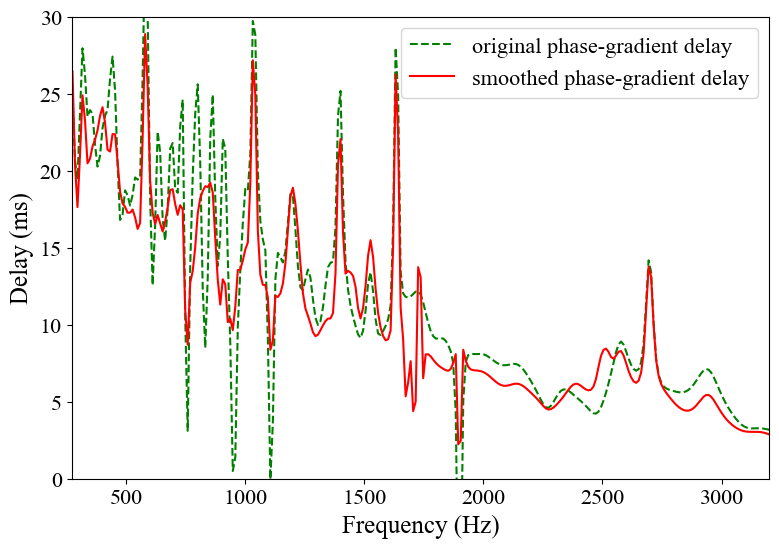

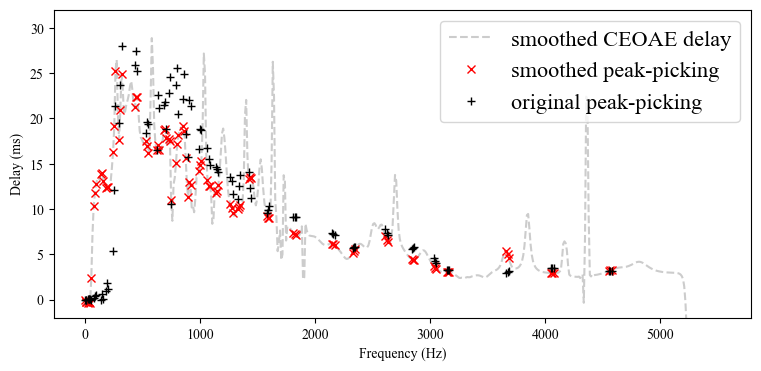

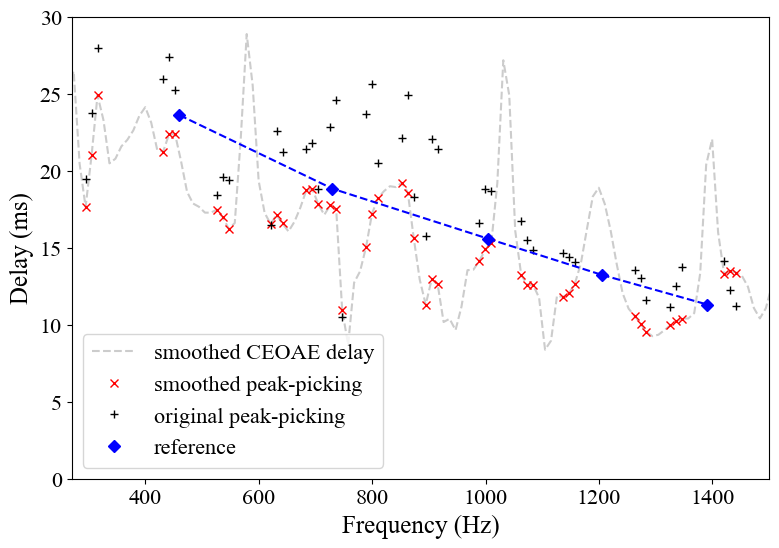

In [8]:
plt.rcParams['font.family'] = 'Times New Roman'
# fig, ax = plt.subplots(figsize=(9, 4))
# ax.plot(phi, np.real(log_SFOAE), "b--", label="Original log(SFOAE)")
# ax.plot(phi_resample, np.real(log_0_SFOAE), "r", label="Smoothed log(SFOAE)")
# plt.legend()
# plt.xlabel("Phi (rad)")
# plt.ylabel("SPL (dB)")
# plt.title("log(SFOAE) before and after cepstral smoothing")
# plt.show()

# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(fx, 1000*original_grad_delay,
        "g--", label="original phase-gradient delay")
ax.plot(fx[:phi_first_loc_max], 1000*smoothed_grad_delay,
        "r", label="smoothed phase-gradient delay")
ax.tick_params(axis='both', which='major', labelsize=16)

# plt.title(
#     f"Comparison of the original and smoothed gradient-delay 30 dB (with cutoff coeff={cutoff_coeff})")
plt.xlim(270, 3200)
plt.ylim(0, 30)
plt.legend(fontsize=16)
plt.xlabel("Frequency (Hz)", fontdict={"fontsize": 18})
plt.ylabel("Delay (ms)", fontdict={"fontsize": 18})
plt.savefig("ceoae_cepstrum_compar.png", dpi=300)
plt.show()
# ------------------------------------------------------------------------------
# MAIN RESULT
peaks_adjust = adjustPeaks(ext_maximas_CEOAE, fx[:phi_first_loc_max])

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(fx[:phi_first_loc_max], 1000*smoothed_grad_delay,
        '0.8', linestyle='--', label='smoothed CEOAE delay')

ax.plot(fx[peaks_adjust], 1000*smoothed_grad_delay[peaks_adjust],
        "rx", label='smoothed peak-picking')

ax.plot(fx[peaks_adjust], 1000*original_grad_delay[peaks_adjust],
        "k+", label='original peak-picking')

# plt.title(f"Smoothed gradient-delay 30 dB (with cutoff coeff={cutoff_coeff})")
# plt.xlim(900, 3150)
plt.ylim(-2, 32)
plt.legend(fontsize=16)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Delay (ms)")
plt.show()

# MAIN RESULT - cut
peaks_adjust = adjustPeaks(ext_maximas_CEOAE, fx[:phi_first_loc_max])

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(fx[:phi_first_loc_max], 1000*smoothed_grad_delay,
        '0.8', linestyle='--', label='smoothed CEOAE delay')

ax.plot(fx[peaks_adjust], 1000*smoothed_grad_delay[peaks_adjust],
        "rx", label='smoothed peak-picking')

ax.plot(fx[peaks_adjust], 1000*original_grad_delay[peaks_adjust],
        "k+", label='original peak-picking')

# reference values
for i, freq_ISOINT in enumerate(freq_ISOINT_list):
    max_idx = max_idx_ISOINT_list[i]
    grad_delay_ISOINT = GD_ISOINT_list[i]
    ax.plot(freq_ISOINT[max_idx], 1000*grad_delay_ISOINT[max_idx],
            "bD", label='reference' if i == 0 else None)
    if i > 0:  # connect points starting from the second point
        ax.plot([freq_ISOINT_list[i-1][max_idx_ISOINT_list[i-1]], freq_ISOINT[max_idx]],
                [1000*GD_ISOINT_list[i-1][max_idx_ISOINT_list[i-1]],
                    1000*grad_delay_ISOINT[max_idx]],
                "b--")
ax.plot(fx_500[max_500], 1000*GD_500, "bD")
ax.plot(fx_750[max_750], 1000*GD_750, "bD")

ax.plot([fx_500[max_500], fx_750[max_750], freq_ISOINT_list[0][max_idx_ISOINT_list[0]]],
        [1000*GD_500, 1000*GD_750, 1000*GD_ISOINT_list[0][max_idx_ISOINT_list[0]]], "b--")

# plt.title(f"Smoothed gradient-delay 30 dB (with cutoff coeff={cutoff_coeff})")
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xlim(270, 1500)
plt.ylim(0, 30)
plt.legend(fontsize=16)
plt.xlabel("Frequency (Hz)", fontdict={"fontsize": 18})
plt.ylabel("Delay (ms)", fontdict={"fontsize": 18})
# plt.savefig("ceoae_cepstrum.png", dpi=300)
plt.show()

